In [1]:
from Models.BaseCNN import BaseCNN
from train_eval import trainNN, validateNN, train_and_validateNN, testNN
from earlystop import EarlyStopper
from processes import initModel, trainModel, loadModel, plotTrain
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## **Data Preparation**

In [2]:
# Read in data
img_size = 128
data_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size)
])

dataset = datasets.ImageFolder(root='lung_colon_image_set', transform=data_transformation)

In [3]:
dataset.class_to_idx

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [4]:
# Set up train and test data
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_data), len(valid_data), len(test_data)

(17500, 3750, 3750)

In [5]:
# 'Colon Adenocarcinoma', 'Colon Benign', 'Lung Adenocarcinoma', 'Lung Benign', 'Lung Squamous Cell Caricnoma'
classes = ('colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc')
# The function to show an image.
def display_img(ax, img, label):
    img = img / 2 + 0.5     # Unnormalize.
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0))) # Convert to (H,W,C)
    ax.set_title(classes[label])
    ax.axis('off')

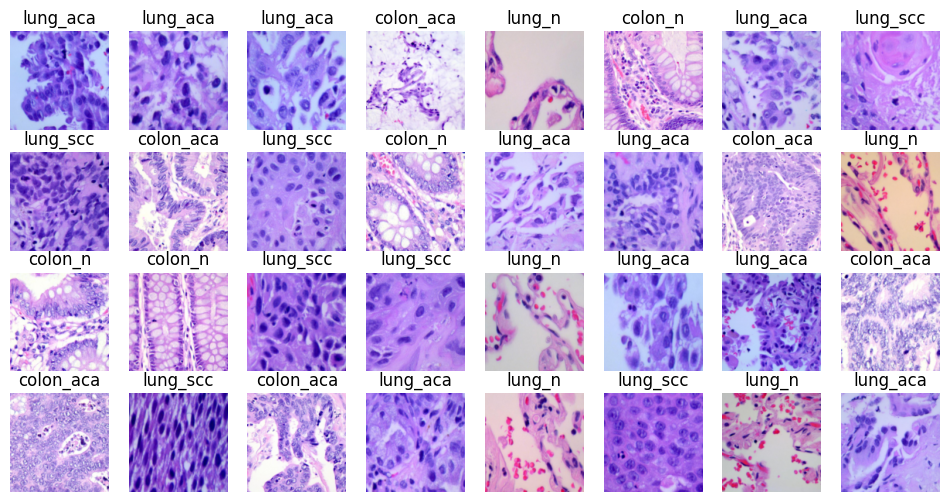

In [6]:
plt.figure(figsize=(12, 6))

# Get a random batch of training images.
images, labels = next(iter(train_loader))

for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)  # Create a subplot for each image
    display_img(ax, images[i], labels[i])

In [7]:
# Set up device
if torch.backends.mps.is_available(): # M1 Mac
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)  

cuda


## **Set Up Training and Validation Steps**

In [11]:
num_epochs = 1
criterion = nn.CrossEntropyLoss()
lr = .0001

In [12]:
def w_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, .02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1, .02)
        nn.init.constant_(m.bias.data, 0)

### ReLU + MaxPool

In [ ]:
model = initModel('relu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
model.apply(w_init)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'relu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### ReLU + AvgPool

In [ ]:
model = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'relu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### LeakyReLU + MaxPool

In [ ]:
model = initModel('lrelu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'lrelu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### LeakyReLU + AvgPool

In [ ]:
model = initModel('relu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'lrelu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### ELU + MaxPool

In [ ]:
model = initModel('elu', 'max', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'elu', 'max', img_size, train_loader, valid_loader, criterion, optimizer, device)

In [ ]:
plotTrain(train_loss, valid_loss)

### ELU + AvgPool

In [ ]:
model = initModel('elu', 'avg', img_size, device, elu_val = 1, lrelu_val = .01)
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loss, valid_loss = trainModel(model, 'elu', 'avg', img_size, train_loader, valid_loader, criterion, optimizer, device)

In [ ]:
plotTrain(train_loss, valid_loss)

## **Evaluate on Testing Data**

### ReLU + MaxPool

In [ ]:
loadModel('relu', 'max', img_size, test_loader, classes, device)

### ReLU + AvgPool

In [ ]:
loadModel('relu', 'avg', img_size, test_loader, classes, device)

### LeakyReLU + MaxPool

In [ ]:
loadModel('lrelu', 'max', img_size, test_loader, classes, device)

### LeakyReLU + AvgPool

In [ ]:
loadModel('lrelu', 'avg', img_size, test_loader, classes, device)

### ELU + MaxPool

In [ ]:
loadModel('elu', 'max', img_size, test_loader, classes, device)

### ELU + AvgPool

In [ ]:
loadModel('elu', 'avg', img_size, test_loader, classes, device)

## **Comparison to other popular CNN Architectures**

Any other popular architectures (feel free to edit / we can decide together)